I use this notebook to draw simulationd data from the data generating process. Furthermore, illustrations of the data set as well as the results of a Monte Carlo estimation of changes in skill prices on the basis of simulation data are produced in this notebook.

In [276]:
# import packages
import matplotlib.pyplot as plt
import statsmodels.api as sms
import seaborn as sns
import pandas as pd
import numpy as np
import sys
import os

# import function of DGP
from MC_simulation.DGP.draw_data import draw_simulation_data

In [278]:
# Define specifying arguments of DGP.
# This follows the descriptions in my thesis, true change in skill prices in fixed at 0.1.
kwargs = {
          # (1) Arguments for price changing process.
          "pi_fun": "pi_fixed",
          "const": [0.0, 0.1]
          }
# set seed for dgp, number of MC iterations and number of workers
np.random.seed(100)
M = 1000
N = 100

# initialize result arrays
utility_on_mean_lmb = np.empty(M)
adj_wage_on_mean_lmb = np.empty(M)
wage_on_mean_lmb = np.empty(M)
wage_on_mean_and_diff_lmb = np.empty(M)

In [279]:
# Start MC loop
for m in range(M):
    # Draw simulatioon data following the specification that is described in my thesis.
    sim_data = draw_simulation_data(
        T=3,
        N=N,
        J=2,
        penalty="quad",
        p_weight=15,
        p_locus=(0.3, 0.7),
        p_exponent=2,
        **kwargs
    )

    idx = pd.IndexSlice

    # Calculate mean task choice in base period
    mean_lmb_base = np.array(
        sim_data.loc[idx[0, :], "lambda"].values +
        sim_data.loc[idx[1, :], "lambda"].values
        )/2

    # Calculate chage in task choice in base period
    diff_lmb_base = np.array(
        sim_data.loc[idx[1, :], "lambda"].values -
        sim_data.loc[idx[0, :], "lambda"].values
        )

    # utility change in base period
    util_change_base = np.array(
        sim_data.loc[idx[1, :], "utility"].values -
        sim_data.loc[idx[0, :], "utility"].values
        )

    # wage change in base period
    wage_change_base = np.array(
        sim_data.loc[idx[1, :], "wage"].values -
        sim_data.loc[idx[0, :], "wage"].values
        )

    # Estimate changes in amenities and skill accumulation in base period
    exog_base = pd.DataFrame(data={
        "const": np.ones(N),
        "mean_lmb_base": mean_lmb_base.astype(float),
        "diff_lmb_base": diff_lmb_base.astype(float),
        "lmb_inter_base": mean_lmb_base.astype(float) *
        diff_lmb_base.astype(float),
        "lmb_0": sim_data.loc[idx[0, :], "lambda"].values.astype(float),
        "lmb_0^2": sim_data.loc[idx[0, :], "lambda"].values.astype(float)**2,
        "lmb_1": sim_data.loc[idx[1, :], "lambda"].values.astype(float),
        "lmb_1^2": sim_data.loc[idx[1, :], "lambda"].values.astype(float)**2,
        "mean_lmb_inter_lmb_0": mean_lmb_base.astype(float) *
        sim_data.loc[idx[0, :], "lambda"].values.astype(float),
        })

    OLS_base_period_result = sms.OLS(
        endog=wage_change_base.astype(float),
        exog=exog_base[[
            # "const",
            # "lmb_0",
            "lmb_1",
            # "lmb_0^2",
            "lmb_1^2",
            # "mean_lmb_base",
            # "diff_lmb_base",
            # "lmb_inter_base"
            ]]
        ).fit()
        # Use estimation result to adjust wages changes for skill and
    # amenity changes in subsequent periods

    # Calculate mean task choice in estimation period
    mean_lmb_est = np.array(
        sim_data.loc[idx[2, :], "lambda"].values +
        sim_data.loc[idx[1, :], "lambda"].values
        )/2

    # Calculate chage in task choice in estimation period
    diff_lmb_est = np.array(
        sim_data.loc[idx[2, :], "lambda"].values -
        sim_data.loc[idx[1, :], "lambda"].values
        )

    # wage change in estimation period
    wage_change_est = np.array(
        sim_data.loc[idx[2, :], "wage"].values -
        sim_data.loc[idx[1, :], "wage"].values
        )

    # wage change in estimation period
    util_change_est = np.array(
        sim_data.loc[idx[2, :], "utility"].values -
        sim_data.loc[idx[1, :], "utility"].values
        )

    # Write exogeneous variables into df
    exog_est = pd.DataFrame(data={
        "const": np.ones(N),
        "mean_lmb_est": mean_lmb_est.astype(float),
        "diff_lmb_est": diff_lmb_est.astype(float),
        "lmb_inter_est": mean_lmb_est.astype(float)*diff_lmb_est.astype(float),
        "lmb_1": sim_data.loc[idx[1, :], "lambda"].values.astype(float),
        "lmb_1^2": sim_data.loc[idx[1, :], "lambda"].values.astype(float)**2,
        "lmb_2": sim_data.loc[idx[2, :], "lambda"].values.astype(float),
        "lmb_2^2": sim_data.loc[idx[2, :], "lambda"].values.astype(float)**2,
        "mean_lmb_inter_lmb_1": mean_lmb_est.astype(float) *
        sim_data.loc[idx[1, :], "lambda"].values.astype(float),
        })

    # Adjust wage change for predicted changes in skills and amentities
    wage_change_est_adjusted = wage_change_est - \
        OLS_base_period_result.predict(
            exog_est[[
                # "mean_lmb_est",
                # "const",
                # "lmb_1",
                "lmb_2",
                # "lmb_1^2",
                "lmb_2^2",
                # "diff_lmb_est",
                # "lmb_inter_est"
                ]]
            )

    # Regress adjusted wage changes on mean_lmb
    pi_tilde = sms.OLS(
        endog=wage_change_est_adjusted.astype(float),
        exog=mean_lmb_est.astype(float)
        ).fit().params.round(6)
    adj_wage_on_mean_lmb[m] = pi_tilde


Based on the results of the MC estimation, create some plots that wil be used in my master's thesis.
First, plot an histogram of the estimation results for price changes. The true value that is used in the DGP is 0.1. 

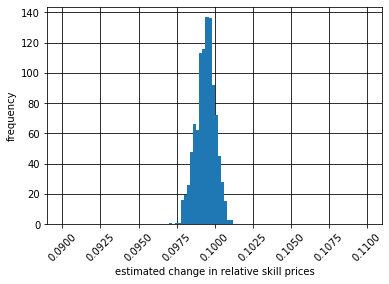

In [281]:
plt.rc('axes', axisbelow=True)
plt.xticks(rotation=45)
plt.xlabel("estimated change in relative skill prices")
plt.ylabel("frequency")
plt.rc('grid', linestyle="-", color='black')
plt.grid(True)
plt.hist(adj_wage_on_mean_lmb, bins=100, range=(0.09, 0.11))
plt.savefig("latex_files\\FIG\\MC_estimation_rslt.png", dpi=450)

Get a heatmap of the correlations coefficients for task choices and their squares in the base period.

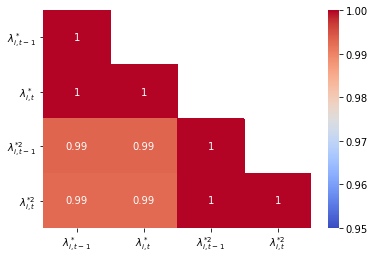

In [282]:
    corr = exog_base[["lmb_0", "lmb_1", "lmb_0^2", "lmb_1^2"]].corr()
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask, k=1)] = True
    fig = sns.heatmap(
        data=corr,
        vmin=0.95,
        vmax=1.0,
        annot=True,
        mask=mask,
        xticklabels=["$\lambda_{i,t-1}^*$", "$\lambda_{i,t}^*$", "$\lambda_{i,t-1}^{*2}$", "$\lambda_{i,t}^{*2}$"],
        cmap="coolwarm"
        )
    fig.set_yticklabels(rotation=0, labels=["$\lambda_{i,t-1}^*$", "$\lambda_{i,t}^*$", "$\lambda_{i,t-1}^{*2}$", "$\lambda_{i,t}^{*2}$"])
    fig.get_figure().savefig("latex_files\\FIG\\corr_heatmap.png", dpi=450)

Get a scatterplot of all simulated combinations of optimal task choices and realized wages with histograms on both axes for one MC iteration (particularly, in the way this is currently set up, for the last MC iteration).

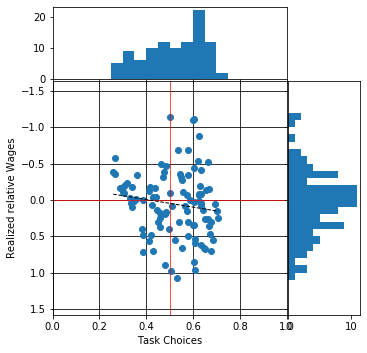

In [283]:
choices = sim_data.loc[idx[0, :], "lambda"].values
wages = sim_data.loc[idx[0, :], "wage"].values


def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.1
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth

    xbins = np.arange(0, lim + binwidth, binwidth/2)
    ybins = np.arange(-lim, lim + binwidth, binwidth)
    
    ax_histx.hist(x, bins=xbins)
    ax_histy.hist(y, bins=ybins, orientation='horizontal')
    
    #ax_vline.plot([0.5, 0.5], [-lim, lim], color='black', lw=.7)
    
    

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(5, 5))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)

# use the previously defined function
scatter_hist(choices, wages, ax, ax_histx, ax_histy)

# vertical line
ax.plot([0.5, 0.5], [wages.max()+.5, wages .min()-.5], color='r', lw=.7)
# horizontal line
ax.plot([0, 1], [0, 0], color='r', lw=.7)
ax.set_xlim(0,1)
ax.set_ylim(wages.max()+.5, wages.min()-.5)
ax.set_xlabel("Task Choices")
ax.set_ylabel("Realized relative Wages")

# add regression line
m, b = np.polyfit(choices.astype(float), wages.astype(float), 1)
ax.plot(np.sort(choices), m*np.sort(choices)+b, linestyle="--", lw=1, color="black")


ax.grid(True)
#plt.savefig("MC_simulation\\FIG\\simulated_data.png", dpi=450)
plt.savefig("latex_files\\FIG\\simulated_data.png", dpi=450, bbox_inches='tight')
plt.show()
